<h1 align="center">Software Introspection for Signaling Emergent Cyber-Social Operations (SIGNAL)</h1>
<h2 align="center">SRI International</h2>
<h3 align="center">In support of DARPA AIE Hybrid AI to Protect Integrity of Open Source Code (SocialCyber)</h3>

### For any questions regarding this notebook, please contact:
* Huascar Sanchez (PI) at [huascar.sanchez@sri.com](mailto:huascar.sanchez@sri.com)
* Briland Hitaj at [briland.hitaj@sri.com](mailto:briland.hitaj@sri.com)

## Training Machine Learning Models on P4G & Transfer Learning Application to LKML Data

**Summary:** In this notebook, we provide a step-by-step demonstration of our training and testing pipeline. In addition to that, we also show the steps taken to adapt the trained machine learning models to the task of classifying developer communications, i.e., *transfer learning*.

### Table of Contents

0. [Getting Started](#getting-started)
1. [Load the P4G (resampled) Data](#p4g-load)
2. [Train a RandomForest classifier on the imbalanced P4G data](#p4g-imbalanced-training)
3. [Train a RandomForest classifier on the balanced P4G data](#p4g-balanced-training)
4. [Conclusions](#conclusions)

### 0. Getting Started <a class="anchor" id="getting-started"></a>

In [1]:
import os
import sys

# adding the parent directory of the current folder to the PATH variable
PARENT_DIR = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(PARENT_DIR)

In [2]:
# import relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# relevant sklearn packages for classification
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

%matplotlib inline

### 1. Load the P4G (resampled) Data <a class="anchor" id="p4g-load"></a>

In [3]:
destination_folder = os.path.join(PARENT_DIR, 'data')

In [4]:
# use pandas to read the respective pickle files
X_train = pd.read_pickle(os.path.join(destination_folder, 'x_train_imbalanced.pkl'))
y_train = pd.read_pickle(os.path.join(destination_folder, 'y_train_imbalanced.pkl'))
X_test = pd.read_pickle(os.path.join(destination_folder, 'x_test_imbalanced.pkl'))
y_test = pd.read_pickle(os.path.join(destination_folder, 'y_test_imbalanced.pkl'))
X_balanced = pd.read_pickle(os.path.join(destination_folder, 'x_resampled_balanced.pkl'))
y_balanced = pd.read_pickle(os.path.join(destination_folder, 'y_resampled_balanced.pkl'))

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_balanced.shape, y_balanced.shape

((3265, 4), (3265,), (172, 4), (172,), (10290, 4), (10290,))

### 2. Train a Random Forest classifier on the imbalanced P4G data <a class="anchor" id="p4g-imbalanced-training"></a>

In [5]:
X_train_filtered = X_train['Unit']
y_train_filtered = y_train.to_numpy()
X_train_filtered.shape, y_train_filtered.shape

((3265,), (3265,))

In [6]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2,
                        norm='l2', encoding='latin-1',
                        ngram_range=(1, 2), stop_words='english')

X_src_imbalanced = tfidf.fit_transform(X_train_filtered).toarray()
y_src_imbalanced = y_train_filtered
X_src_imbalanced.shape, y_src_imbalanced.shape

((3265, 2699), (3265,))

Obtain the TF-IDF vectors for the testing set

In [7]:
X_test_filtered = X_test['Unit']
y_test_filtered = y_test.to_numpy()
X_test_filtered.shape, y_test_filtered.shape

X_test_src = tfidf.transform(X_test_filtered).toarray()
y_test_src = y_test_filtered
X_test_src.shape, y_test_src.shape

((172, 2699), (172,))

#### 2.1 Training

In [8]:
rf_clf_on_imbalanced_data = RandomForestClassifier(n_estimators=20).fit(X_src_imbalanced, y_src_imbalanced)

#### 2.2 Testing

In [9]:
predictions_test_set = rf_clf_on_imbalanced_data.predict(X_test_src)

In [10]:
acc_on_imbalanced_set = accuracy_score(y_test_src, predictions_test_set)
acc_on_imbalanced_set

0.5755813953488372

In [11]:
cf_matrix = confusion_matrix(y_test_src, predictions_test_set)
cf_matrix

array([[ 1,  3,  3,  1,  0,  2,  0,  0,  0,  0],
       [ 2, 48,  1,  0,  0,  2,  0,  0,  1,  0],
       [ 0, 11,  8,  1,  0,  0,  0,  1,  1,  1],
       [ 1,  4,  1,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0, 19,  1,  0,  2,  1],
       [ 0,  2,  1,  0,  0,  1,  3,  0,  1,  0],
       [ 1,  9,  2,  0,  0,  0,  1,  5,  0,  1],
       [ 1,  2,  0,  0,  0,  1,  0,  0,  4,  0],
       [ 0,  2,  1,  1,  0,  0,  1,  2,  0,  1]])

In [12]:
# labels
class_names = ['task-related-inquiry', 'credibility-appeal', 'logical-appeal', 
               'personal-related-inquiry', 'source-related-inquiry', 'donation-information', 
               'foot-in-the-door', 'emotion-appeal', 'self-modeling', 'personal-story']

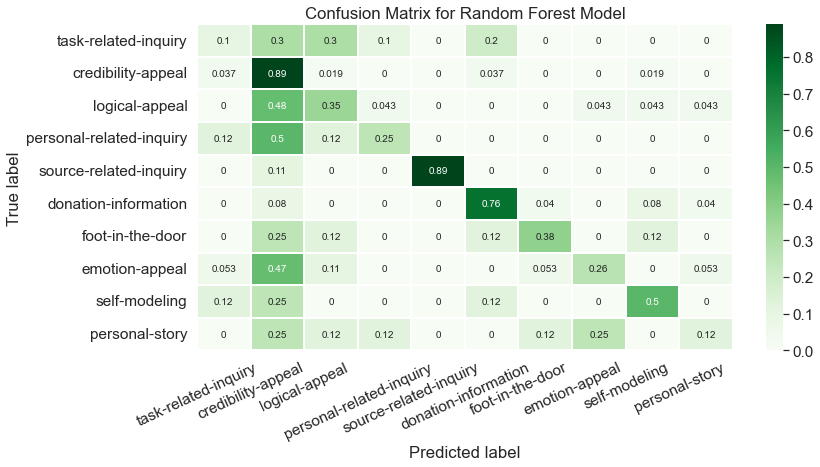

In [13]:
# Get and reshape confusion matrix data
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(12,6))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [14]:
print(classification_report(y_test_src, predictions_test_set))

              precision    recall  f1-score   support

           0       0.17      0.10      0.12        10
           1       0.57      0.89      0.70        54
           2       0.47      0.35      0.40        23
           3       0.40      0.25      0.31         8
           4       1.00      0.89      0.94         9
           5       0.76      0.76      0.76        25
           6       0.50      0.38      0.43         8
           7       0.62      0.26      0.37        19
           8       0.44      0.50      0.47         8
           9       0.25      0.12      0.17         8

    accuracy                           0.58       172
   macro avg       0.52      0.45      0.47       172
weighted avg       0.56      0.58      0.54       172



### 3. Train a Random Forest classifier on the balanced P4G data <a class="anchor" id="p4g-balanced-training"></a>

In [15]:
X_train_balanced_filtered = X_balanced['Unit']
y_train_balanced_filtered = y_balanced.to_numpy()
X_train_balanced_filtered.shape, y_train_balanced_filtered.shape

((10290,), (10290,))

In [16]:
tfidf_balanced = TfidfVectorizer(sublinear_tf=True, min_df=2, 
                                 norm='l2', encoding='latin-1',
                                 ngram_range=(1, 2), stop_words='english')

X_src_balanced = tfidf_balanced.fit_transform(X_train_balanced_filtered).toarray()
y_src_balanced = y_train_balanced_filtered
X_src_balanced.shape, y_src_balanced.shape

((10290, 7285), (10290,))

Obtain the TF-IDF vectors for the testing set

In [17]:
X_test_filtered = X_test['Unit']
y_test_filtered = y_test.to_numpy()
X_test_filtered.shape, y_test_filtered.shape

X_test_src = tfidf_balanced.transform(X_test_filtered).toarray()
y_test_src = y_test_filtered
X_test_src.shape, y_test_src.shape

((172, 7285), (172,))

#### 3.1 Training

In [18]:
rf_clf_on_balanced_data = RandomForestClassifier(n_estimators=20).fit(X_src_balanced, y_src_balanced)

#### 3.2 Testing

In [19]:
predictions_test_set_on_balanced = rf_clf_on_balanced_data.predict(X_test_src)

In [20]:
acc_on_balanced_set = accuracy_score(y_test_src, predictions_test_set_on_balanced)
acc_on_balanced_set

0.5813953488372093

In [21]:
cf_matrix = confusion_matrix(y_test_src, predictions_test_set_on_balanced)
cf_matrix

array([[ 2,  2,  2,  1,  0,  2,  0,  0,  1,  0],
       [ 3, 44,  3,  0,  0,  0,  0,  1,  2,  1],
       [ 0,  6,  9,  3,  0,  1,  1,  1,  1,  1],
       [ 1,  2,  0,  5,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  8,  0,  0,  0,  0,  0],
       [ 1,  3,  1,  0,  0, 16,  1,  0,  3,  0],
       [ 0,  0,  1,  0,  0,  2,  3,  2,  0,  0],
       [ 1,  6,  3,  1,  0,  0,  1,  6,  1,  0],
       [ 1,  1,  1,  0,  0,  0,  0,  0,  5,  0],
       [ 0,  1,  1,  0,  0,  0,  1,  2,  1,  2]])

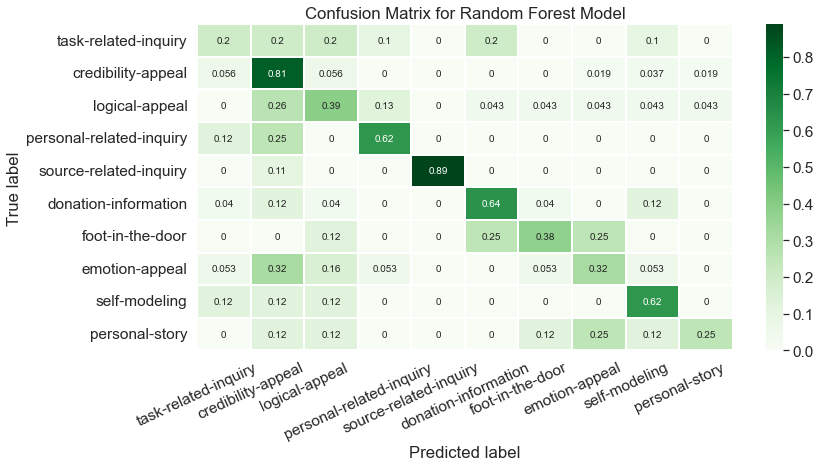

In [22]:
# Get and reshape confusion matrix data
cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(12,6))
sns.set(font_scale=1.4)
sns.heatmap(cf_matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [23]:
print(classification_report(y_test_src, predictions_test_set_on_balanced))

              precision    recall  f1-score   support

           0       0.22      0.20      0.21        10
           1       0.67      0.81      0.73        54
           2       0.43      0.39      0.41        23
           3       0.50      0.62      0.56         8
           4       1.00      0.89      0.94         9
           5       0.76      0.64      0.70        25
           6       0.43      0.38      0.40         8
           7       0.50      0.32      0.39        19
           8       0.36      0.62      0.45         8
           9       0.50      0.25      0.33         8

    accuracy                           0.58       172
   macro avg       0.54      0.51      0.51       172
weighted avg       0.58      0.58      0.57       172



### 4. Conclusions <a class="anchor" id="conclusions"></a>

* Training a baseline RandomForest Classifier on the **imbalanced** data results in a model with **~0.575** accuracy.
* Training a baseline RandomForest Classifier on the **balanced** data results in a model with **~0.581** accuracy.

### Finding Better Models, i.e., GridSearch

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
rf = RandomForestClassifier()
parameters = {
              'n_estimators': [5, 10, 15, 20], 
              'max_depth': [2, 4, 8, 16, 32, None]
             }

In [26]:
cv = GridSearchCV(rf, parameters, cv=5)

In [27]:
cv.fit(X_src_balanced, y_src_balanced)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 15, 20]})

In [30]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{}\t(+/-{})\tfor {}'.format(round(mean, 3), round(std * 2, 3), params))

In [31]:
print_results(cv)

BEST PARAMS: {'max_depth': None, 'n_estimators': 20}

0.209	(+/-0.039)	for {'max_depth': 2, 'n_estimators': 5}
0.247	(+/-0.079)	for {'max_depth': 2, 'n_estimators': 10}
0.261	(+/-0.074)	for {'max_depth': 2, 'n_estimators': 15}
0.319	(+/-0.041)	for {'max_depth': 2, 'n_estimators': 20}
0.25	(+/-0.03)	for {'max_depth': 4, 'n_estimators': 5}
0.297	(+/-0.055)	for {'max_depth': 4, 'n_estimators': 10}
0.376	(+/-0.045)	for {'max_depth': 4, 'n_estimators': 15}
0.381	(+/-0.026)	for {'max_depth': 4, 'n_estimators': 20}
0.349	(+/-0.049)	for {'max_depth': 8, 'n_estimators': 5}
0.441	(+/-0.041)	for {'max_depth': 8, 'n_estimators': 10}
0.472	(+/-0.026)	for {'max_depth': 8, 'n_estimators': 15}
0.506	(+/-0.033)	for {'max_depth': 8, 'n_estimators': 20}
0.459	(+/-0.034)	for {'max_depth': 16, 'n_estimators': 5}
0.546	(+/-0.05)	for {'max_depth': 16, 'n_estimators': 10}
0.595	(+/-0.023)	for {'max_depth': 16, 'n_estimators': 15}
0.617	(+/-0.026)	for {'max_depth': 16, 'n_estimators': 20}
0.62	(+/-0.018)	for {